# Using Keras CNN to Recognize Digits on MNIST dataset


* **1. Introduction**
* **2. Data preparation**
    * 2.1 Load data and EDA
    * 2.2 Check for null and missing values
    * 2.3 Normalization
    * 2.4 Reshape
    * 2.5 Gain some intuision into the dataset
    * 2.6 Label encoding
    * 2.7 Split training and valdiation set
* **3. CNN**
    * 3.1 Define the model
    * 3.2 Set the optimizer and annealer
    * 3.3 Data augmentation
    * 3.4 Fit the model
* **4. Evaluate the model**
    * 4.1 Confusion matrix
* **5. Prediction**

## 1. Introduction

In general, this is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then I will focus on the CNN modeling and evaluation.

I achieved 99.671% of accuracy with this CNN trained in 1h10 on a single CPU (i7-4700MQ @2400GHz). NOTE: By using nvidia GPU, which supports keras-gpu, computation will be much faster!

This Notebook follows three main parts:

* The data preparation
* The CNN modeling and evaluation
* The results prediction

Following, all the necessary modules are being imported

In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
np.random.seed(1)
# For data manipulation and analysis
import pandas as pd
# Machine learning library
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
# For interacting with the operating system
import os 
# Deep learning framework Keras
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


## 2. Data preparation


### 2.1 Load data and EDA
Read the data using pandas' read_csv method and let's look at the dataset info to see if everything is alright

In [2]:
TRAIN_DATAPATH = './MNIST/train.csv'
train = pd.read_csv(TRAIN_DATAPATH)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
#shape of our train data
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [4]:
TEST_DATAPATH = './MNIST/test.csv'
test = pd.read_csv(TEST_DATAPATH)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [5]:
#shape of our test data
test.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

In [6]:
#Have a look on the first 5 rows of train data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split train data into X_train and Y_train in order to feed our CNN 

In [7]:
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"], axis = 1) 

Let's see how how many images of each label exist

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

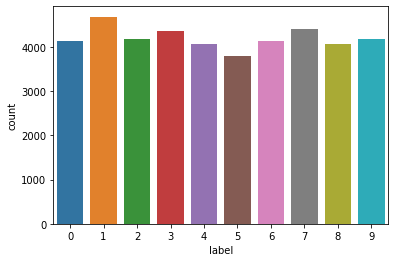

In [8]:
sns.countplot(Y_train)
Y_train.value_counts()

Let's have a look into the data grouped by into labels 

In [9]:
train.groupby('label').describe()

pixel0                                     pixel1       ... pixel782  \
        count mean  std  min  25%  50%  75%  max   count mean  ...      75%   
label                                                          ...            
0      4132.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4132.0  0.0  ...      0.0   
1      4684.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4684.0  0.0  ...      0.0   
2      4177.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4177.0  0.0  ...      0.0   
3      4351.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4351.0  0.0  ...      0.0   
4      4072.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4072.0  0.0  ...      0.0   
5      3795.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3795.0  0.0  ...      0.0   
6      4137.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4137.0  0.0  ...      0.0   
7      4401.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4401.0  0.0  ...      0.0   
8      4063.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4063.0  0.0  ...      0.0   
9      4188.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4188.0  0.0  ...      0.0   

           pixel783                                     
       max    count mean  std  min  25%  50%  75%  max  
label                                                   
0      0.0   4132.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0   4684.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0   4177.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0   4351.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0   4072.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5      0.0   3795.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6      0.0   4137.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7      0.0   4401.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8      0.0   4063.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9      0.0   4188.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[10 rows x 6272 columns]

### 2.2 Check for null and missing values


In [10]:
# Check the train data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
# Check the test data
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No corrupted images found (images with missing values). So we can safely go ahead.

### 2.3 Normalization
We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [12]:
# Normalize the data
X_train = X_train / 255
test = test / 255

### 2.4 Reshape

Before training, we’ll preprocess the data by reshaping it into the shape the network
expects. Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices. 


In [13]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### 2.5 Gain some intuition into the dataset

[1, 2, 3, 4, 5, 6, 7, 8, 9]


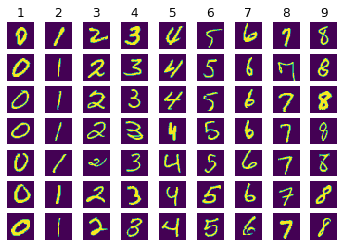

In [14]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [i for i in range(1,10)]
print(classes)
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx][:,:,0])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### 2.6 Label encoding

We also need to categorically encode the labels, so as to formulate the one-hot-vectors for our CNN

In [15]:
Y_train = to_categorical(Y_train)

### 2.7 Split training and valdiation set 
In order to monitor during training the accuracy of the model on data it has never
seen before, you’ll create a validation. I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

train_test_split() of scikit-learn splits randomly the initial train data to the new train data and validation data. By doing so, we avoid the case to train a CNN in a specific range of labels, which may dramatically defer from the images' labels in the validation set.

In [16]:
# Set the random seed
random_seed = 1
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

## 3. CNN


### 3.1 Define the model

Keras API is build in the top of Tensorflow. It is simple in use as you just add one layer at a time.

I choosed my first 2 convolutional layers to be of size 32 with kernel size 5 x 5. Padding = 'Same' which means “pad in such a way as to have an output with the same width and height as the input. The later 2 convolutional layers are of of size 64 with kernel size 3 X 3. Again padding in such a way as to have an output with the same width and height as the input.

In [17]:
# Set the CNN model 

model = Sequential()


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [18]:
# Here’s what the network looks like now:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

### 3.2 Define the optimizer and annealer

In [19]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
# NOTE: we use categorical_crossentropy, as we perform multilabel classification
# NOTE: we evaluate our model in terms of accuracy 
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. It's obviously better to have a learning rate decrease as we approach the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

In [20]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
epochs = 30
batch_size = 86

### 3.3 Data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. 

Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would
never overfit.

Data augmentation takes the approach of generating more training data
from existing training samples, by augmenting the samples via a number of random
transformations that yield believable-looking images. 

The goal is that at training time,
your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data and generalize better.

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

Note: Disable vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

### 3.4 Fit the model 

In this notebook a model has already being trained and we just load the model. In case you want to change the cnn architecture and train a different model, you are free to do us just by giving a different path to model.

In [23]:
MODELS_DIR = './models/'
while True:
    model_name = input("Enter model name: ")
    if model_name:
        break
path_to_model = MODELS_DIR + model_name

if os.path.exists(path_to_model):
    # load model
    model = load_model(path_to_model)
    # summarize model.
    model.summary()
else:
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val, Y_val),
                                  verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size,
                                  callbacks = [learning_rate_reduction])
    # Save model
    if not os.path.exists(MODELS_DIR):
        os.makedir(MODELS_DIR)
    model.save(path_to_model)

Enter model name: model.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling

## Evaluate model

### 4.1 Confusion matrix

Confusion matrix can be very useful to see the drawbacks of our model. Specifically, we will check how our model classify each digit

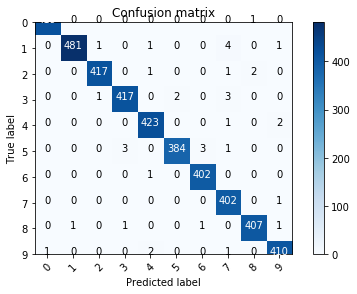

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

## Prediction

It's time to predict and evaluate our model in the unseen dataset.

In [25]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [26]:
submission = pd.concat([pd.Series(range(1,len(results) + 1),name = "ImageId"), results], axis = 1)
submission.to_csv("./results/mnist_predicted.csv", index=False)